### Read raw data

In [5]:
import pandas as pd
import logging
from statistics import mean
import os

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from numpy import array
from numpy import hstack

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from seaborn import lineplot

logger = logging.getLogger('recession_predictor')
logger.setLevel(logging.DEBUG)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [6]:
### READ DATA INTO ONE DATAFRAME

data = pd.concat([pd.read_csv('data/TB3SMFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T1YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T5YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T10YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/USREC.csv', index_col='DATE')
                 ], axis=1)
data.index = pd.to_datetime(data.index)

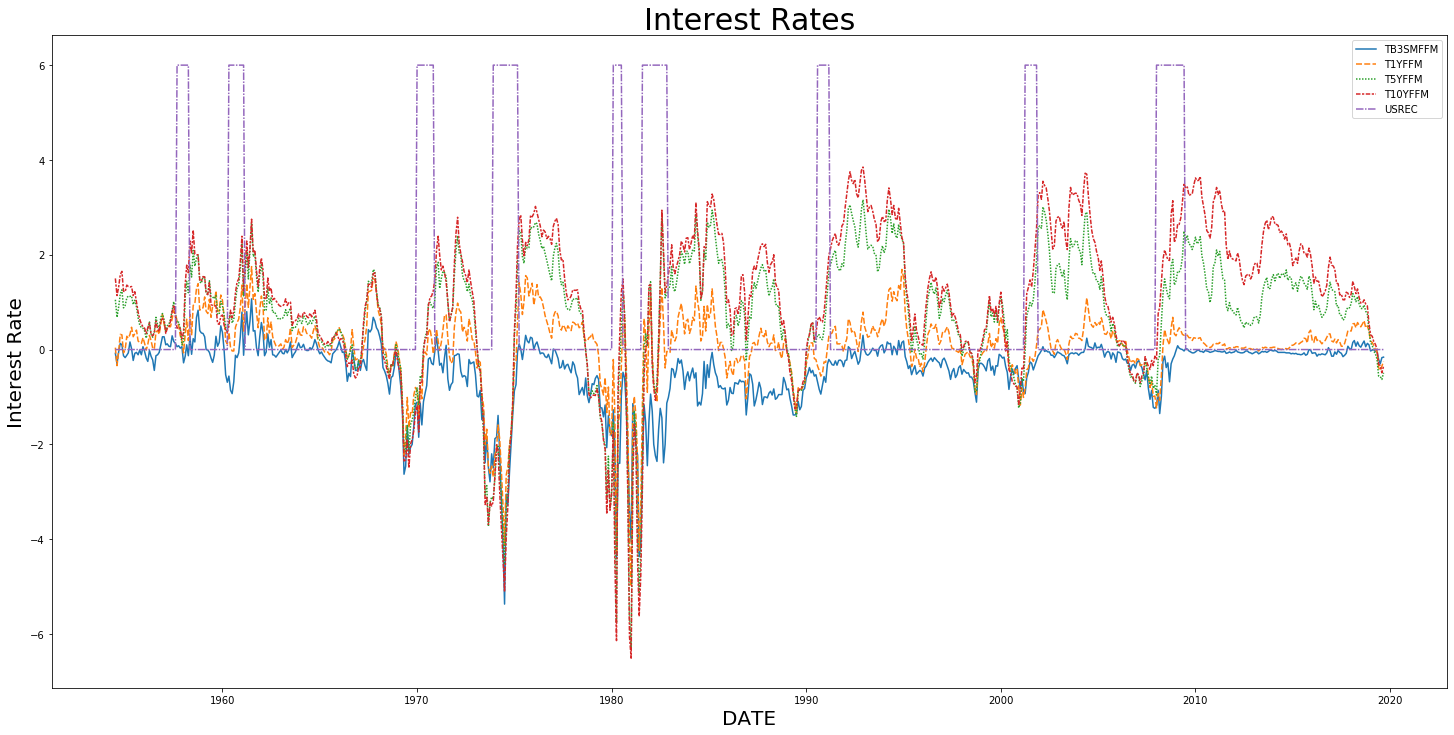

In [22]:
graph = data.copy(deep=True)
graph['USREC'] = graph['USREC'] * 6
fig, ax = plt.subplots(figsize=(25,12)) 
ax.set_title('Interest Rates', size= 30)
plt.xlabel('Date', size=20)
plt.ylabel('Interest Rate', size=20)
ax = lineplot(hue="event",
                   units="subject", estimator=None,
                   data=graph)

### Shift 12 months, create 6 month buckets

In [23]:
data['future_rec_6m_12'] = data['USREC'].shift(-10).iloc[::-1].rolling(6, min_periods=0).sum().iloc[::-1]

In [24]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def scale(X):
    # Scale features
    scaler = MinMaxScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X)
    return scaled_features, scaler

def graph_results(index, predictions, scaled_target):
    fig, ax = plt.subplots(figsize=(25,12)) 
    #myFmt = mdates.DateFormatter("%y-%m")
    #ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.set_title('Preds', size= 30)
#    wide_df = data[['preds', target_col]]
    wide_df = pd.DataFrame(index=index)
    wide_df['predictions'] = predictions
    wide_df['target'] = scaled_target
    ax = lineplot(data=wide_df)
    plt.xlabel('Year', size=20)
    plt.ylabel('# of future months in recession', size=20)
    plt.xticks(rotation=45)
    plt.grid(which='major');

In [34]:
dataset = data.reset_index()[['TB3SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'future_rec_6m_12']].to_numpy()
time_index = data.reset_index()[['DATE']].to_numpy()

In [26]:
def load_data(dataset, n_steps):
    X, y = split_sequences(dataset, n_steps)
    X = X[:-19]
    y = y[:-19]
    return X, y
    
def create_model(nodes, activation, timesteps, n_features, dropout, optimizer, loss):
    model = Sequential()
    model.add(LSTM(nodes, activation=activation, input_shape=(timesteps, n_features), dropout=dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    
    return model
    
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs):
  
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    
    pred = model.predict(X_test)
    
    return mean_squared_error(y_test, pred)
    
#fit_cross_val(train, test, 10, 'relu', .1, 'adam', 'mse' 200)

def cross_val(np_data, timesteps, n_folds, nodes, activation, dropout, optimizer, loss, epochs):
    scores = []
    X, y = load_data(np_data, timesteps)
    skf = KFold(n_splits=n_folds, random_state=None, shuffle=False)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print ("Running Fold", i+1, "/", n_folds, end='')
        model = None # Clearing the NN.
        model = create_model(nodes, activation, timesteps, 4, dropout, optimizer, loss)
        score = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index], epochs)
        scores.append(score)
        print(f", score = {score}")
        
    return mean(scores)





In [27]:
cross_val(np_data=dataset,
          timesteps=6,
          n_folds=3,
          nodes=10,
          activation='relu',
          dropout=0,
          optimizer='adam',
          loss='mse', 
          epochs=5)


Running Fold 1 / 3WARNING:tensorflow:From C:\Users\elawa\AppData\Local\conda\conda\envs\keras_tutorial\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
, score = 4.677268657904491
Running Fold 2 / 3, score = 1.9958045787138594
Running Fold 3 / 3, score = 2.7438933964141174


3.1389888776774892

In [28]:
results = {}

In [64]:
results

{(1, 1, 0): 2.5129931752403056,
 (1, 1, 0.1): 2.5449508705530453,
 (1, 1, 0.2): 2.5677995599274785,
 (1, 1, 0.3): 2.810859372381926,
 (1, 1, 0.4): 2.521703293235579,
 (1, 4, 0): 2.6193204305203004,
 (1, 4, 0.1): 2.5033469317924033,
 (1, 4, 0.2): 2.71626455277108,
 (1, 4, 0.3): 3.0831915686787315,
 (1, 4, 0.4): 2.7081727891159724,
 (1, 8, 0): 4.333493860076861,
 (1, 8, 0.1): 3.0419441833322436,
 (1, 8, 0.2): 2.9941895249396087,
 (1, 8, 0.3): 2.67365827697583,
 (1, 8, 0.4): 2.872933427250894,
 (1, 12, 0): 2.7517692887659977,
 (1, 12, 0.1): 3.959948205231038,
 (1, 12, 0.2): 2.8171167380731776,
 (1, 12, 0.3): 2.987318237864837,
 (1, 12, 0.4): 2.8593374106860243,
 (10, 1, 0): 2.530952707034621,
 (10, 1, 0.1): 2.444521872250156,
 (10, 1, 0.2): 2.483264798508358,
 (10, 1, 0.3): 2.4479939887671285,
 (10, 1, 0.4): 2.425966638821847,
 (10, 4, 0): 7.673501223898018,
 (10, 4, 0.1): 3.789801053097657,
 (10, 4, 0.2): 3.4024664104804927,
 (10, 4, 0.3): 3.243551484520965,
 (10, 4, 0.4): 2.784553208056

In [65]:
for nodes in [1000]:
    for timesteps in [1,4,8,12]:
        for dropout in [0,.1,.2,.3,.4]:
            results[(nodes, timesteps, dropout)] = cross_val(np_data=dataset,
                                                             timesteps=timesteps,
                                                             n_folds=3,
                                                             nodes=nodes,
                                                             activation='relu',
                                                             dropout=dropout,
                                                             optimizer='adam',
                                                             loss='mse', 
                                                             epochs=200)

Running Fold 1 / 3, score = 3.218790702137096
Running Fold 2 / 3, score = 3.795050160661321
Running Fold 3 / 3, score = 1.77853316668359
Running Fold 1 / 3, score = 3.489826585996832
Running Fold 2 / 3, score = 2.232940918305468
Running Fold 3 / 3, score = 1.800816583057465
Running Fold 1 / 3, score = 3.6050244814421855
Running Fold 2 / 3, score = 2.059188981184011
Running Fold 3 / 3, score = 1.842905885097319
Running Fold 1 / 3, score = 3.5503130695133107
Running Fold 2 / 3

KeyboardInterrupt: 

In [67]:
min(results, key=results.get)
lst = list(zip(*[sorted(d.items()) for d in input_list]))


SyntaxError: positional argument follows keyword argument (<ipython-input-67-aa6503f9064d>, line 1)

In [49]:
# choose a number of time steps
n_steps = 4
# convert into input/output
X, y = split_sequences(dataset, n_steps)
time_steps_crop = time_index[n_steps-1:]
X_train = X[0:514]
y_train = y[0:514]
ts_train = time_steps_crop[0:514]
X_test = X[514:]
y_test = y[514:]
ts_test = time_steps_crop[514:]
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

model = create_model(nodes=10, activation='relu', timesteps=n_steps, n_features=4, dropout=.4, optimizer='adam', loss='mse')

In [50]:
model.fit(X, y, epochs=200, verbose=0)

In [51]:
pred_t = model.predict(X)
#pred = model.predict(X_test)

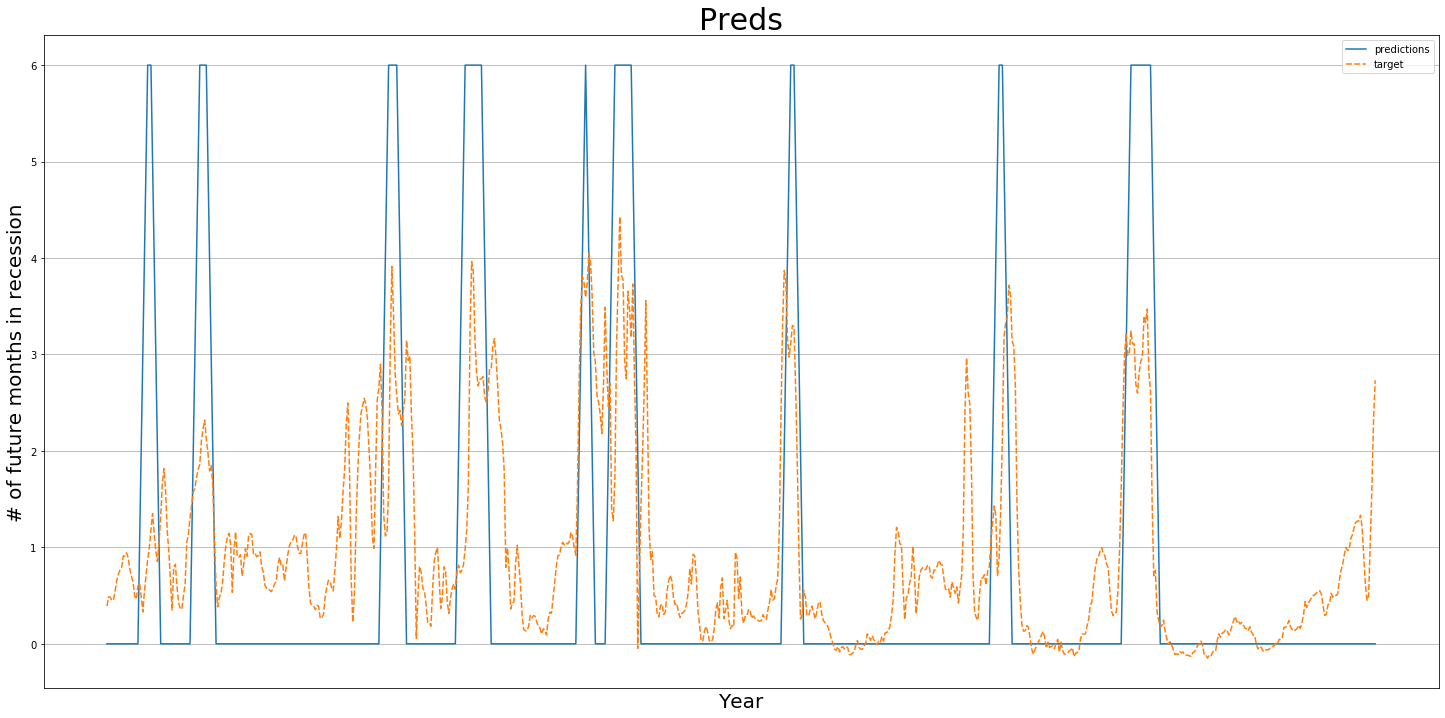

In [52]:
graph_results([], y, pred_t)